In [14]:
import net
import cv2
from matplotlib import pyplot as plt
import utils
import numpy as np

用my.jpg做测试

In [15]:
p_net = net.PNet("./mtcnn/det1.caffemodel")
image = cv2.imread('my.jpg').transpose(2, 0, 1)[None]
confidence, bbox = p_net(image)
print(confidence)
print(bbox)

[[[[9.11337664e-07]]

  [[9.99999089e-01]]]]
[[[[-0.8295494 ]]

  [[ 5.25484717]]

  [[ 4.38221211]]

  [[ 8.41461643]]]]


读取图片，并做归一化处理

In [16]:
image = cv2.imread('deep_img/face.jpg')  # BGR
image = image[..., ::-1]  # RGB
print(image.shape)
# 归一化
input_image = (image - 127.5) * 0.0078125
input_image = cv2.resize(input_image, (150, 150))
print(input_image.shape)
scale = input_image.shape[0] / image.shape[0]
input_image = input_image.transpose(2, 1, 0)[None]
input_image.shape

(499, 500, 3)
(150, 150, 3)


(1, 3, 150, 150)

用PNet网络对图片进行处理，找出建议框

In [17]:
p_net = net.PNet("./mtcnn/det1.caffemodel")
# p_net.load_params('./mtcnn/det1.caffemodel')
confidence, reg = p_net(input_image)
confidence.shape, reg.shape

((1, 2, 70, 70), (1, 4, 70, 70))

找建议框：

Before NMS: 1073
After NMS: 576


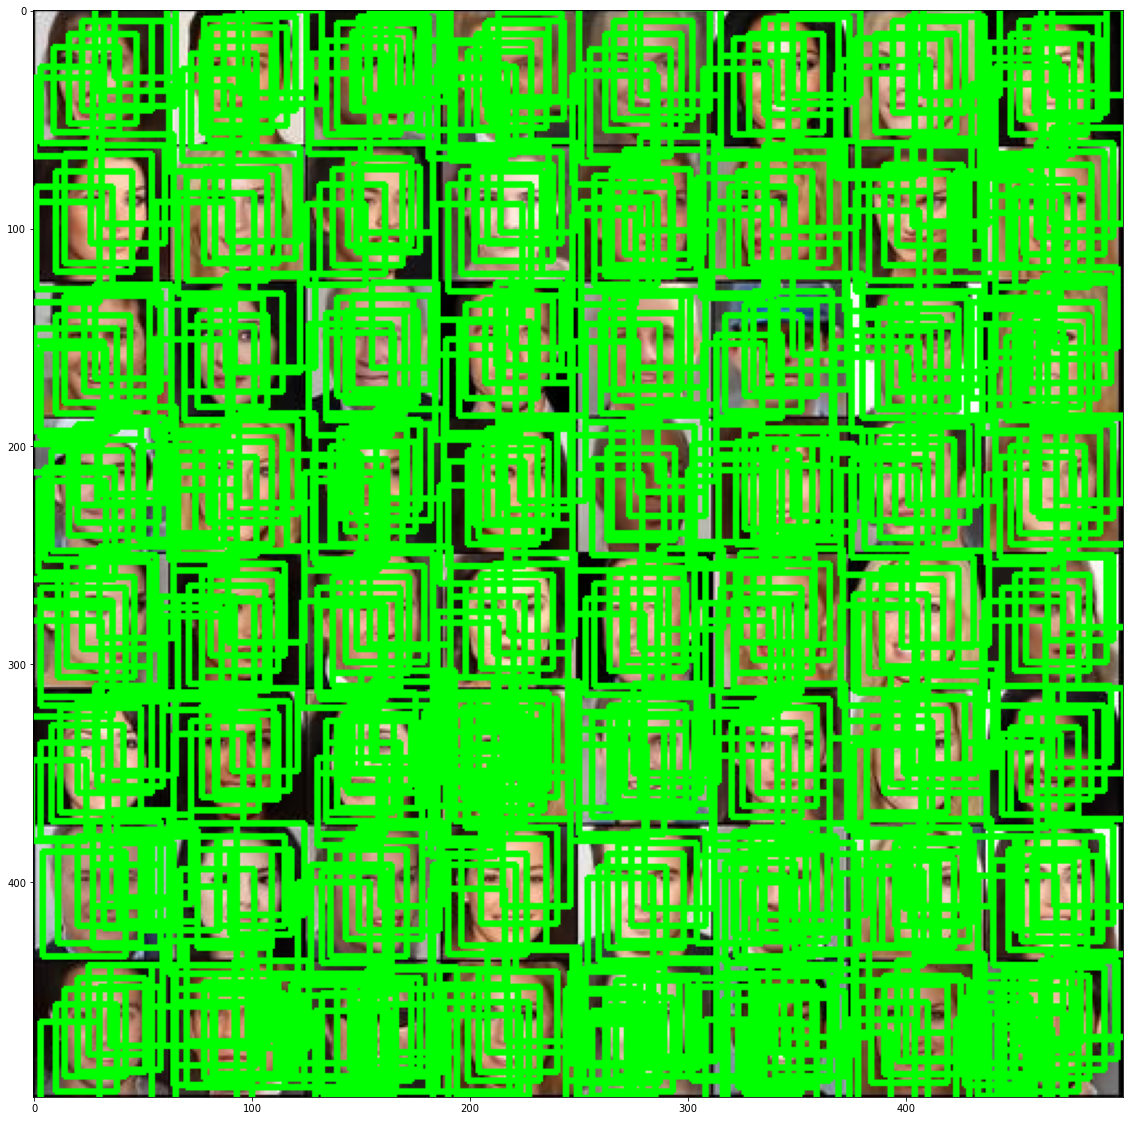

In [18]:
raw_image = cv2.imread('./deep_img/face.jpg')
ys, xs = np.where(confidence[0, 1] > 0.5)  # 返回的是y轴坐标，x轴坐标
stride = 2
cell_size = 12
bbox = []
show = raw_image.copy()
# 找出建议框
for y, x in zip(ys, xs):
    score = confidence[0, 1, y, x]
    # 先计算滑窗的位置
    bx = (x * stride + 1) / scale
    by = (y * stride + 1) / scale
    br = (x * stride + cell_size) / scale
    bb = (y * stride + cell_size) / scale

    # 再对结果进行修正
    reg_x = reg[0, 0, y, x]
    reg_y = reg[0, 1, y, x]
    reg_r = reg[0, 2, y, x]
    reg_b = reg[0, 3, y, x]

    dw = br - bx + 1
    dh = bb - by + 1

    bx = bx + reg_x * dw
    by = by + reg_y * dh
    br = br + reg_r * dw
    bb = bb + reg_b * dh

    bbox.append(utils.BBox(bx, by, br, bb, score))

# NMS限制
print(f'Before NMS: {len(bbox)}')
output = utils.nms(bbox, 0.7)
print(f'After NMS: {len(output)}')

# 在原图上画出建议框
for b in output:
    bx, by, br, bb = b.locations()
    bx, by, br, bb = np.round([bx, by, br, bb]).astype(np.int64)
    cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 2)

plt.figure(figsize=(20, 20))
plt.imshow(show[..., ::-1])
plt.show()